# Example of Minion image processing

## import image

<IPython.core.display.Javascript object>


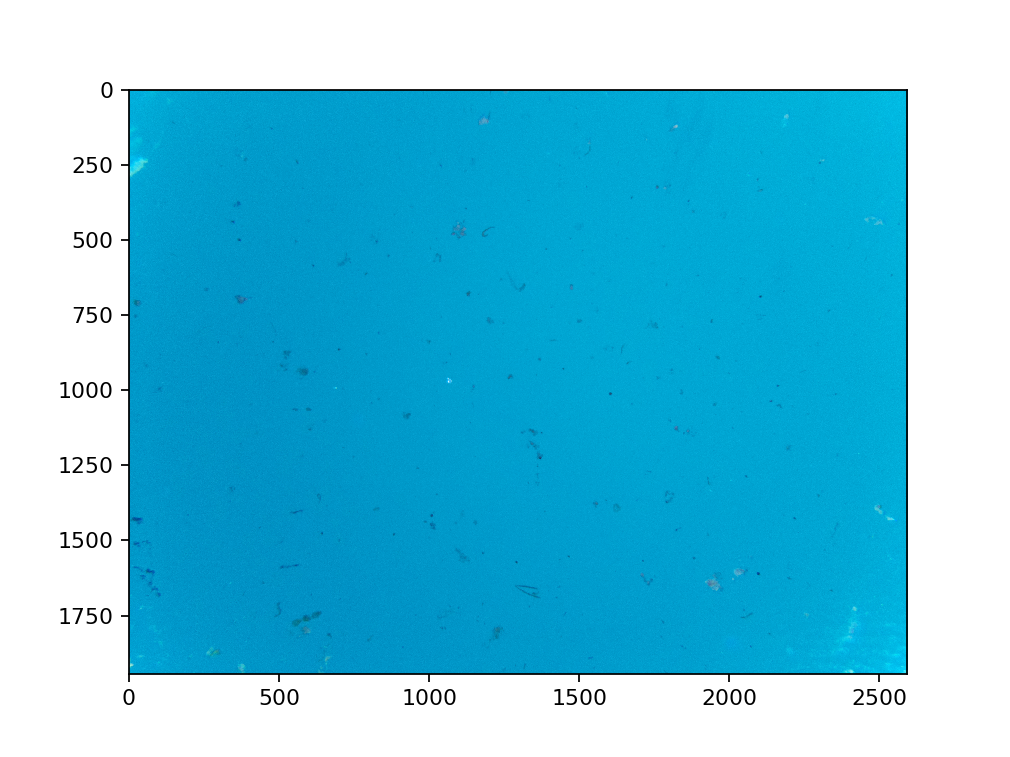

In [213]:
%matplotlib notebook
import numpy as np
from skimage import io, filters, color, measure, exposure, morphology, util
from scipy import misc
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import math


directory='/Users/colleen/Projects/Minions/minion_2_pics/'
photo_name='2019-12-16_15-08-25.jpg'
#directory='/Users/colleen/Projects/Minions/minion_3_pics/'
#photo_name='2019-12-18_08-02-39.jpg'
photo = io.imread(os.path.join(directory,photo_name))
plt.figure()
plt.imshow(photo)


## Convert images to grayscale and highlight brownish colors

In [214]:
photo_grey = color.rgb2grey(photo)
photo_grey=util.img_as_ubyte(photo_grey)
photo_red=photo[:,:,0]
photo_blue=photo[:,:,2]
photo_brown=photo_red-photo_blue


# Remove background using gaussian blur of the fast fourier transform

## sigma is the size of the standard deviation of the gaussian blur.  I chose 8 after testing values for these images.  This should blur fairly large particles into the background, and enable them to still be detected (not subtracted with the background).

## Also need to add artificial "pad" to the edges of the image so that the gaussian blur does not produces artifacts at the edges of the image.  I just repeated the edge rows and columns 100 times along the edges

## First make the "padded" image, apply the FFT, use FFT-shift, multiply by the gaussian blur kernal which is the same dimensions as the padded image, inverse shift, and inverse FFT the image.  Trim off the padding.  Result is gaussian blur of the image.  Do this for both the greyscale and the brown-highlighted versions of the image.

<IPython.core.display.Javascript object>


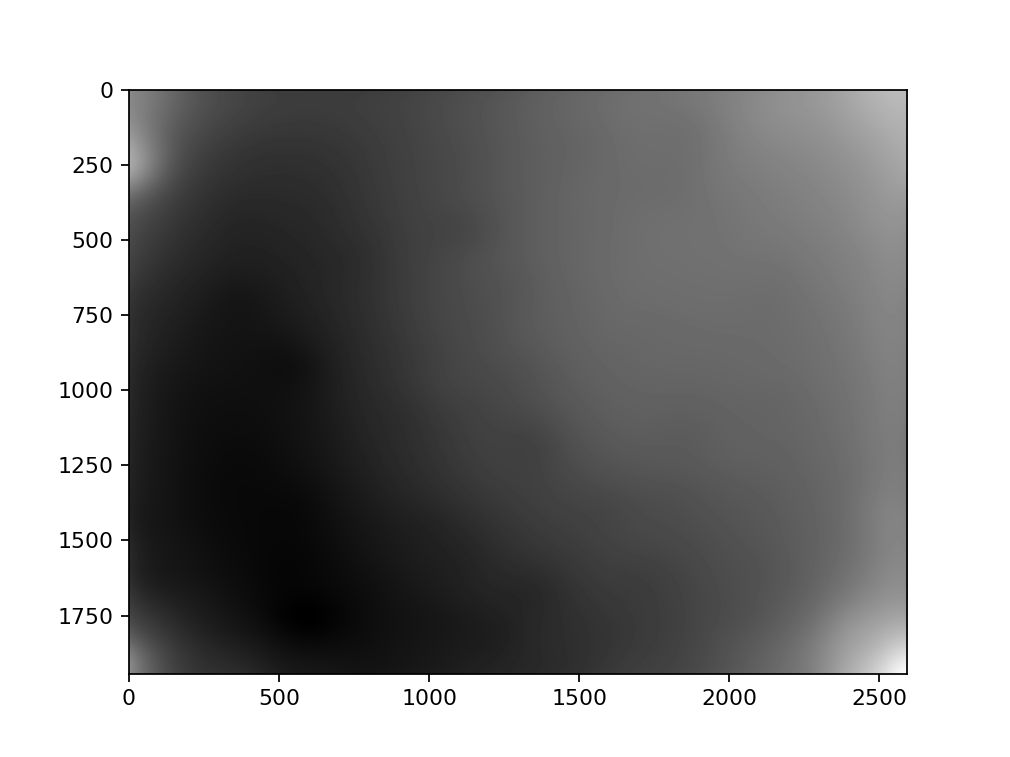

<IPython.core.display.Javascript object>


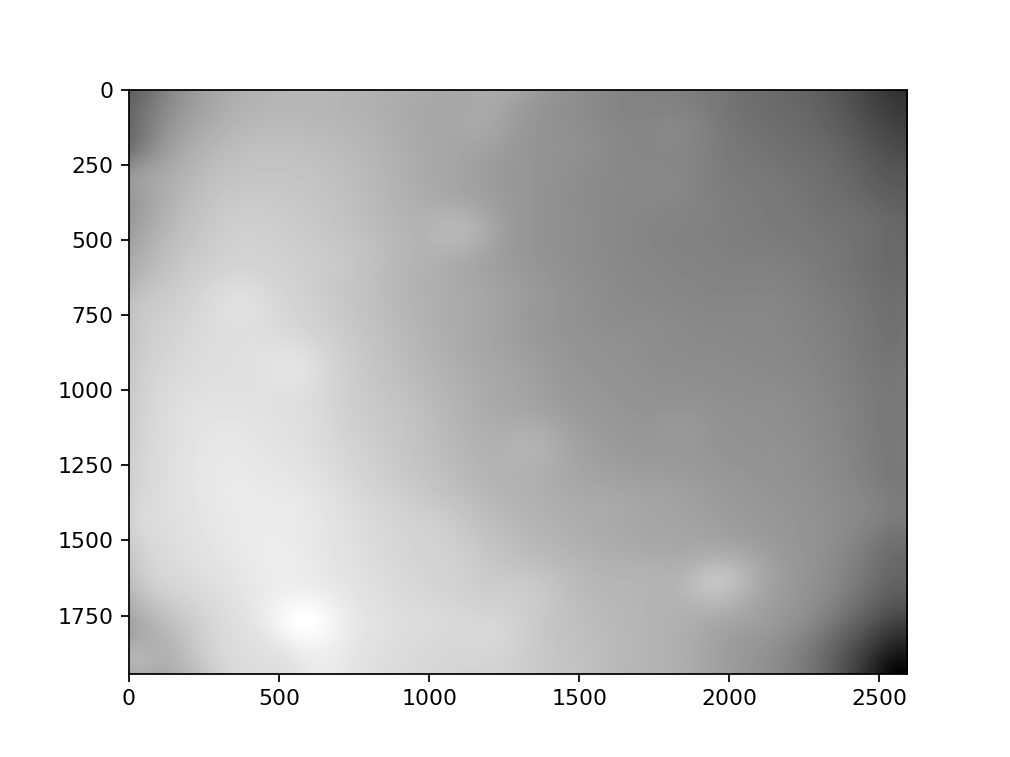

In [215]:
sigma=8
pad=100
top_padding=np.array(np.zeros_like(photo_grey[0:pad,:]))
top_padding[:,:]=photo_grey[0,:]
bottom_padding=np.array(np.zeros_like(photo_grey[0:pad,:]))
bottom_padding[:,:]=photo_grey[np.shape(photo_grey)[0]-1,:]
padded_photo=np.concatenate((top_padding,np.array(photo_grey),bottom_padding))
left_padding=np.array(np.zeros_like(padded_photo[:,0:pad]))
left_padding=np.transpose(left_padding)
left_padding[:,:]=padded_photo[:,0]
left_padding=np.transpose(left_padding)
right_padding=np.array(np.zeros_like(padded_photo[:,0:pad]))
right_padding=np.transpose(right_padding)
right_padding[:,:]=padded_photo[:,np.shape(photo_grey)[1]-1]
right_padding=np.transpose(right_padding)
padded_photo=np.concatenate((left_padding,padded_photo,right_padding),axis=1)
photo_dimensions=np.shape(padded_photo)
nrows=photo_dimensions[1]
ncols=photo_dimensions[0]
cy, cx = ncols/2, nrows/2
x = np.linspace(0, nrows, nrows)
y = np.linspace(0, ncols, ncols)
X, Y = np.meshgrid(x, y)
gmask = np.exp(-(((X-cx)/sigma)**2 + ((Y-cy)/sigma)**2))
photo_grey_fft = np.fft.fft2(padded_photo) #disk shape over which median value is calculated must be larger than the largest particle
photo_grey_fft=np.fft.fftshift(photo_grey_fft)
blur_image=photo_grey_fft*gmask
blur_image_dimensions=np.shape(blur_image)
photo_grey_ifftshifted=np.fft.ifftshift(blur_image)
photo_grey_ifft = np.fft.ifft2(photo_grey_ifftshifted)
photo_grey_ifft_trimmed=photo_grey_ifft[pad:blur_image_dimensions[0]-pad,pad:blur_image_dimensions[1]-pad]
plt.figure()
plt.imshow(np.abs(photo_grey_ifft_trimmed),cmap=plt.cm.gray)

top_brown_padding=np.array(np.zeros_like(photo_brown[0:pad,:]))
top_brown_padding[:,:]=photo_brown[0,:]
bottom_brown_padding=np.array(np.zeros_like(photo_brown[0:pad,:]))
bottom_brown_padding[:,:]=photo_brown[np.shape(photo_brown)[0]-1,:]
padded_brown_photo=np.concatenate((top_brown_padding,np.array(photo_brown),bottom_brown_padding))
left_brown_padding=np.array(np.zeros_like(padded_brown_photo[:,0:pad]))
left_brown_padding=np.transpose(left_brown_padding)
left_brown_padding[:,:]=padded_brown_photo[:,0]
left_brown_padding=np.transpose(left_brown_padding)
right_brown_padding=np.array(np.zeros_like(padded_brown_photo[:,0:pad]))
right_brown_padding=np.transpose(right_brown_padding)
right_brown_padding[:,:]=padded_brown_photo[:,np.shape(photo_brown)[1]-1]
right_brown_padding=np.transpose(right_brown_padding)
padded_brown_photo=np.concatenate((left_brown_padding,padded_brown_photo,right_brown_padding),axis=1)

photo_brown_fft = np.fft.fft2(padded_brown_photo) #disk shape over which median value is calculated must be larger than the largest particle
photo_brown_fft=np.fft.fftshift(photo_brown_fft)
blur_brown_image=photo_brown_fft*gmask
blur_brown_image_dimensions=np.shape(blur_brown_image)
photo_brown_ifftshifted=np.fft.ifftshift(blur_brown_image)
photo_brown_ifft = np.fft.ifft2(photo_brown_ifftshifted)
photo_brown_ifft_trimmed=photo_brown_ifft[pad:blur_brown_image_dimensions[0]-pad,pad:blur_brown_image_dimensions[1]-pad]
plt.figure()
plt.imshow(np.abs(photo_brown_ifft_trimmed),cmap=plt.cm.gray)


## Now subtract the background from the image using the blurred image.

<IPython.core.display.Javascript object>


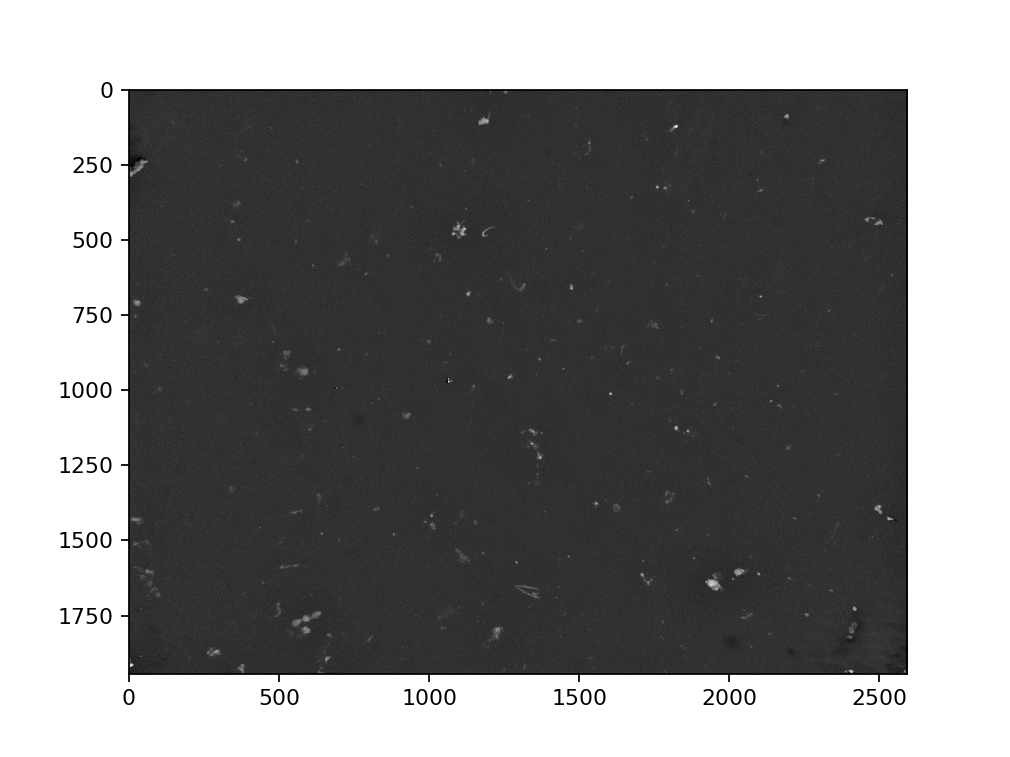

<IPython.core.display.Javascript object>


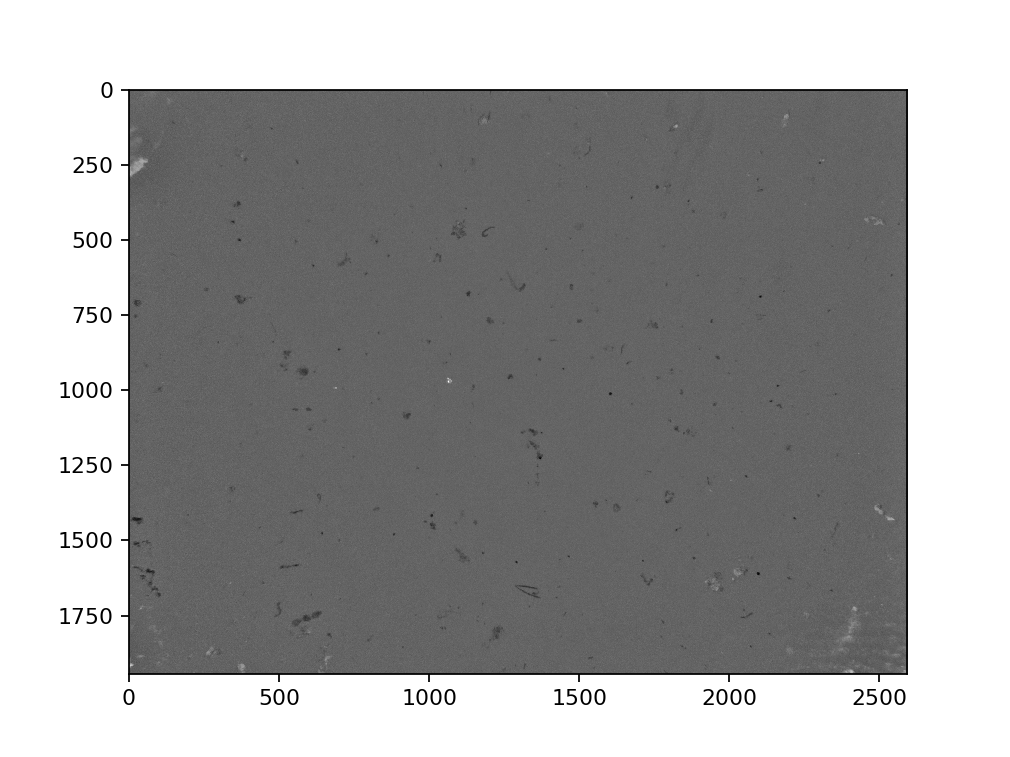

In [216]:
photo_grey_fft_diff = np.abs(photo_grey_ifft_trimmed) - np.median(photo_grey)  #difference between median filtered image and the median value of a blank image.  Use this to indicate variation in the background intensity across the image space.
photo_grey_nobg = photo_grey-photo_grey_fft_diff #background subtracted from the grey-scale image.  This step is especially necessary if the lighting is not even across the entire image (e.g. top of image is brighter than the bottom of the image)


photo_brown_fft_diff = np.abs(photo_brown_ifft_trimmed) - np.median(photo_brown)  #difference between median filtered image and the median value of a blank image.  Use this to indicate variation in the background intensity across the image space.
photo_brown_nobg = photo_brown-photo_brown_fft_diff #background subtracted from the grey-scale image.  This step is especially necessary if the lighting is not even across the entire image (e.g. top of image is brighter than the bottom of the image)

plt.figure()
plt.imshow(np.abs(photo_brown_nobg),cmap=plt.cm.gray)
plt.figure()
plt.imshow(np.abs(photo_grey_nobg),cmap=plt.cm.gray)


## Look at the histogram of pixel intensities of the background-subtracted image

<IPython.core.display.Javascript object>


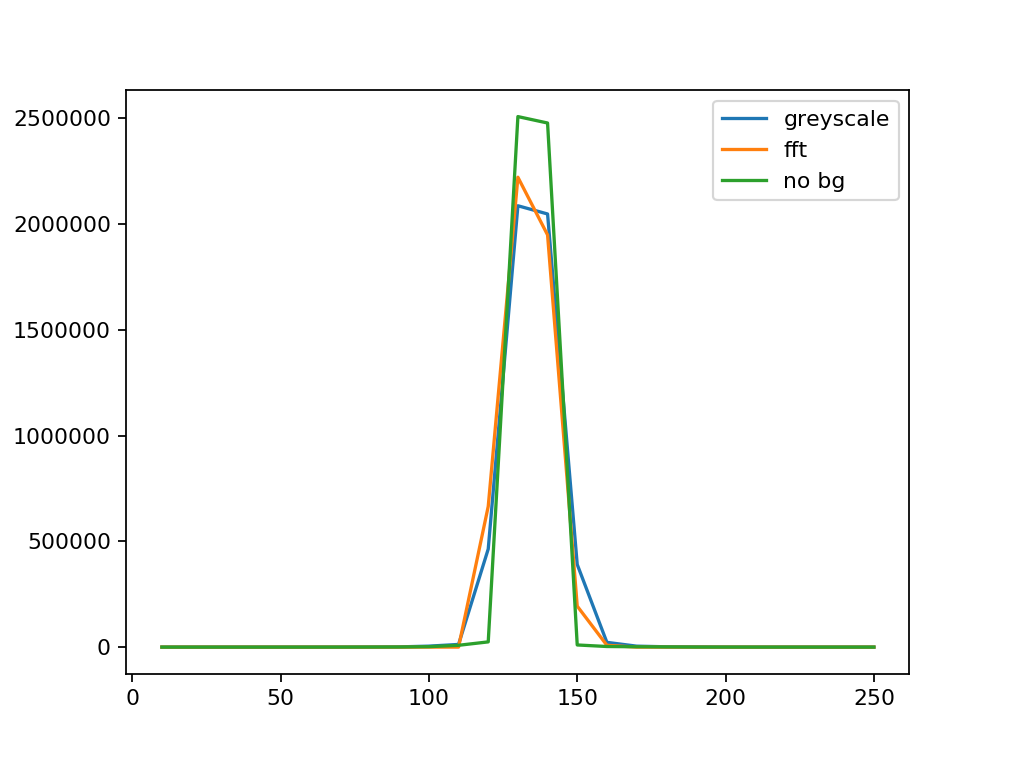

In [217]:
bins=np.arange(0,255,10)
hist_grey=np.histogram(photo_grey,bins=bins)
hist_grey_fft=np.histogram(photo_grey_ifft_trimmed,bins=bins)
hist_grey_nobg=np.histogram(photo_grey_nobg,bins=bins)

plt.figure()
plt.plot(bins[1:],hist_grey[0],label='greyscale')
plt.plot(bins[1:],hist_grey_fft[0],label='fft')
plt.plot(bins[1:],hist_grey_nobg[0],label='no bg')
plt.legend()


## Identify potential particles based on intensity threshold.
## Changes in background lighting affect whether particles appear brighter or darker than the mean image value.  I found that a value of 120 was good for dividing night and day-time images.  The threshold is set to 1.5 standard deviations above or below the mean pixel intensity in both the greyscale and brown-highlighted image.

<IPython.core.display.Javascript object>


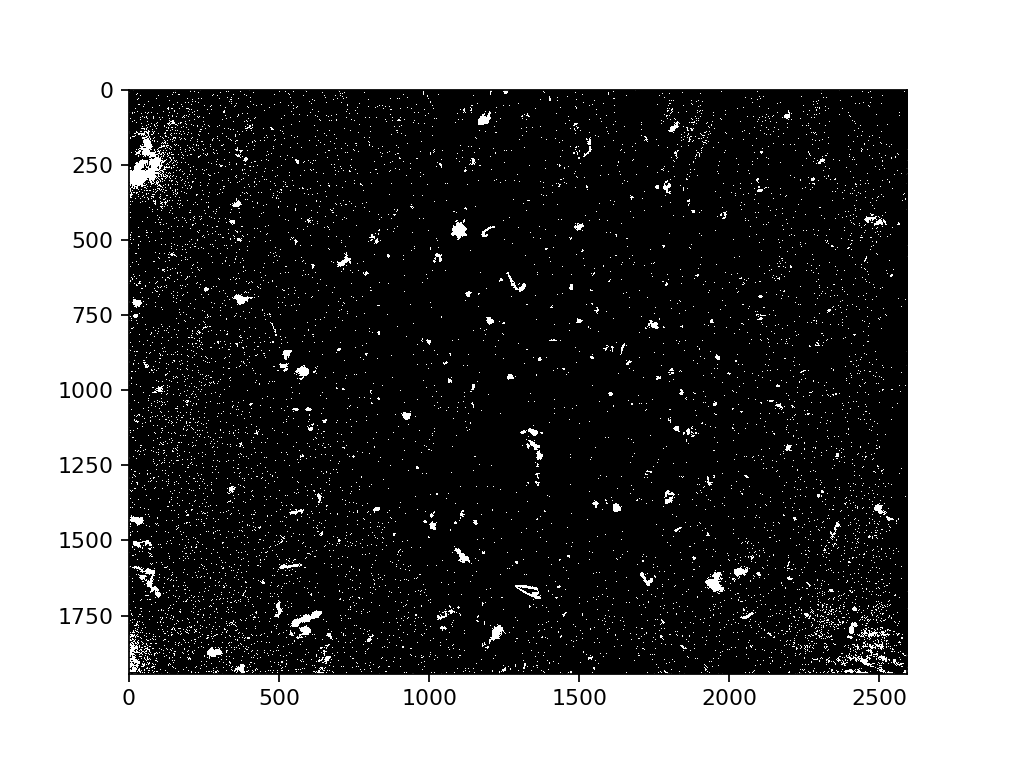

In [218]:
markers = np.zeros_like(photo_grey_nobg)
if np.mean(photo_grey_nobg) < 120:
    print('y')
    markers[photo_grey_nobg <=np.mean(photo_grey_nobg)+(1.5*np.std(photo_grey_nobg))] = 0
    markers[photo_grey_nobg >np.mean(photo_grey_nobg)+(1.5*np.std(photo_grey_nobg))] = 255
    markers[photo_brown_nobg >np.mean(photo_brown_nobg)+(1.5*np.std(photo_brown_nobg))] = 255
else:
    markers[photo_grey_nobg <=np.mean(photo_grey_nobg)-(1.5*np.std(photo_grey_nobg))] = 255
    markers[photo_grey_nobg >np.mean(photo_grey_nobg)-(1.5*np.std(photo_grey_nobg))] = 0
    markers[photo_brown_nobg >np.mean(photo_brown_nobg)+(1.5*np.std(photo_brown_nobg))] = 255
    
markers_fill = ndi.morphology.binary_fill_holes(markers)
markers_fill[markers_fill==True]=255
labeled_particles, _ = ndi.label(markers_fill)

plt.figure()
plt.imshow(markers_fill,cmap=plt.cm.gray)


## Find particles with sharp edges so we can exclude blurry smudges or object above the imagine window.

## First erode the edges of the particles to create an image the masks the interior area of the potential particles.  Apply a Sobel filter to the greyscale image, with the interior mask applied so that only values at the edge of the particles will be counted.

<IPython.core.display.Javascript object>


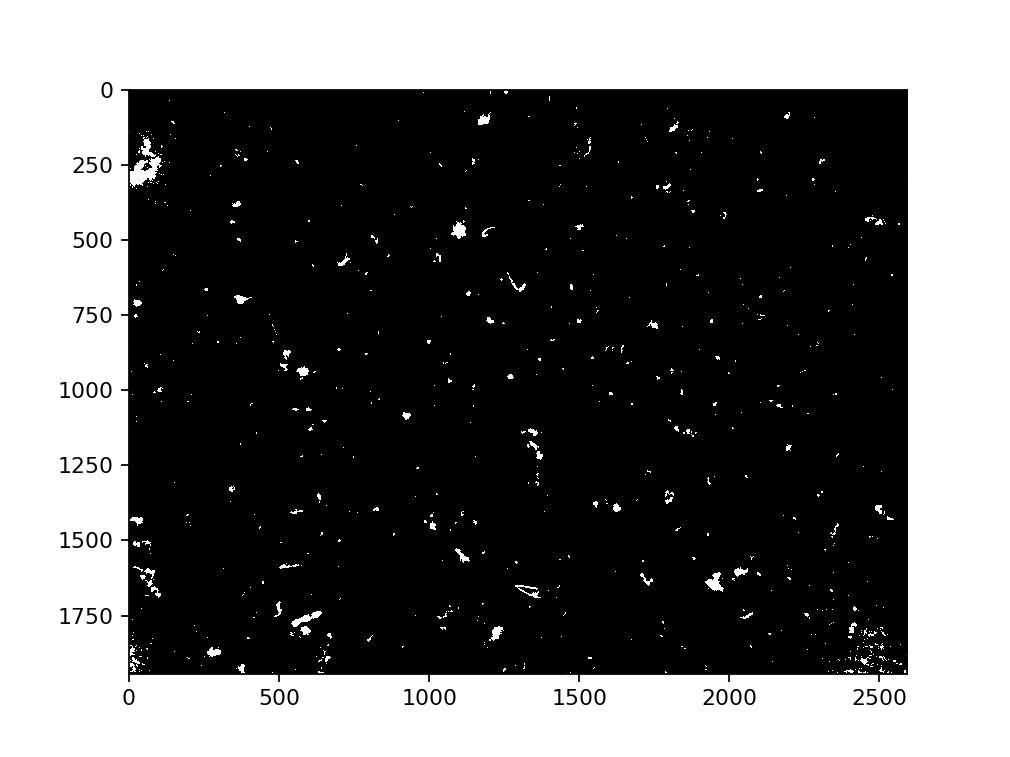

<IPython.core.display.Javascript object>


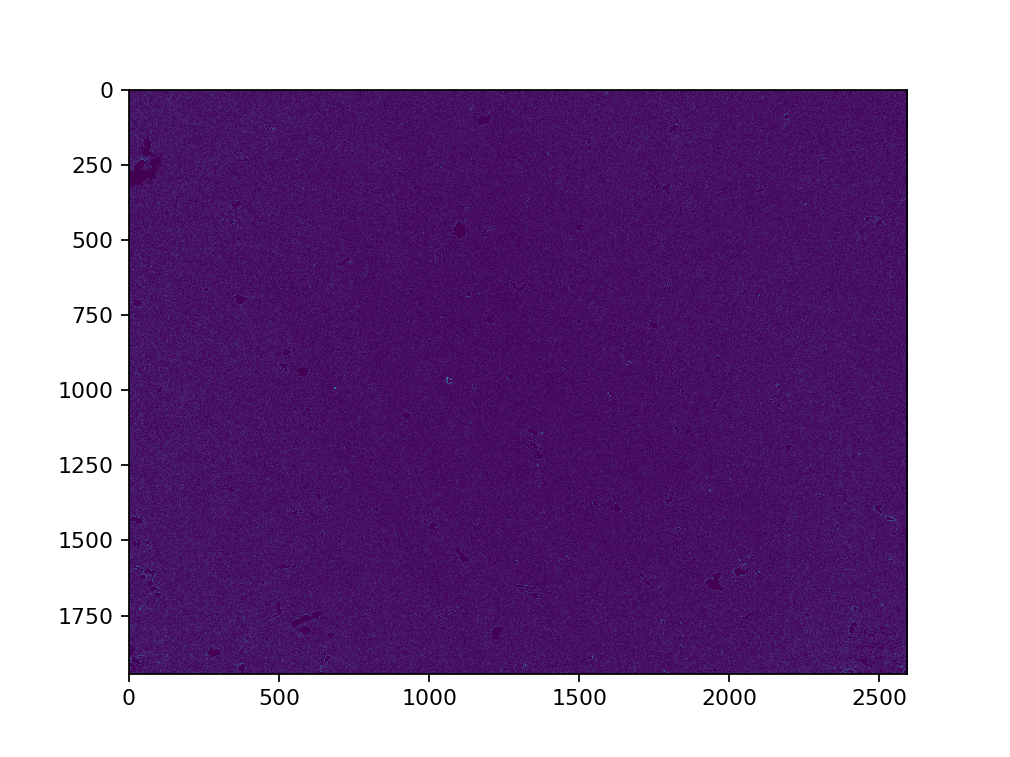

In [219]:
particle_erode = morphology.erosion(markers_fill, selem = morphology.disk(1))
plt.figure()
plt.imshow(particle_erode,cmap=plt.cm.gray)

from skimage.filters import sobel
elevation_map = sobel(photo_grey)
elevation_map[particle_erode>0]=0
plt.figure()
plt.imshow(elevation_map)


## Set threshold of what a sharp (in-focus) edge is based on the pixel intensity

## Based on trial and error, I chose 4 standard deviations above the mean Sobel filtered pixel intensity.  This seems to reduce detection of object that are in the background (swimmers), but some transient "particles" still show up.  I don't think we can avoid this.

<IPython.core.display.Javascript object>


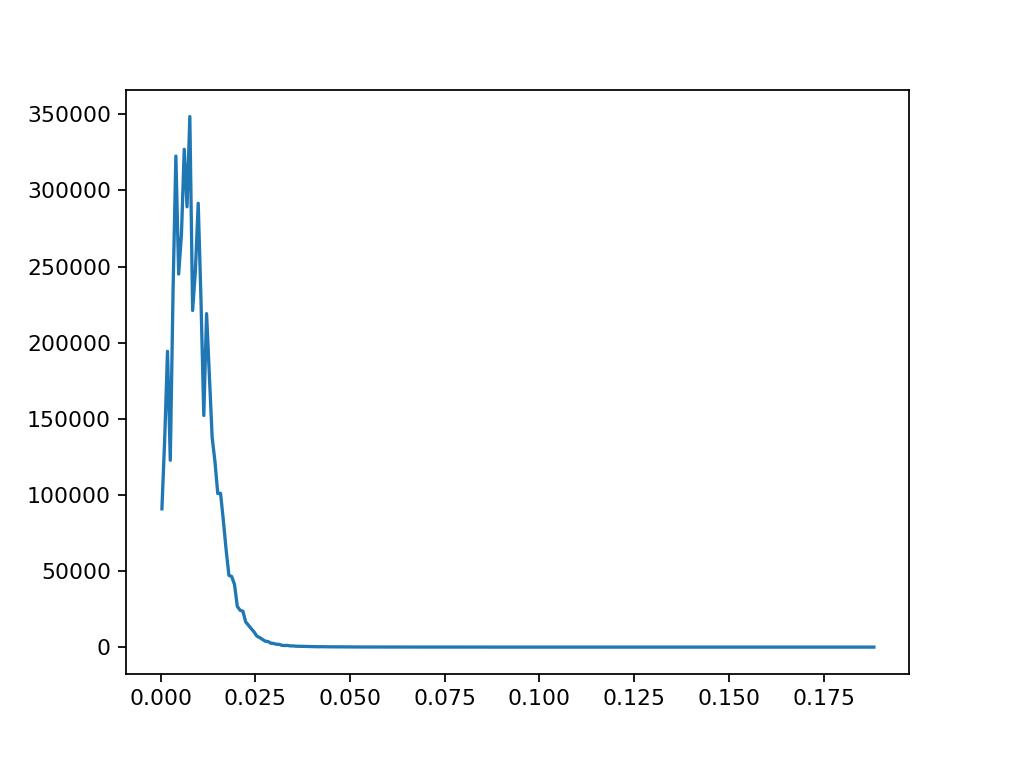

In [220]:
histo = exposure.histogram(elevation_map)
plt.figure()
plt.plot(histo[1],histo[0])

<IPython.core.display.Javascript object>


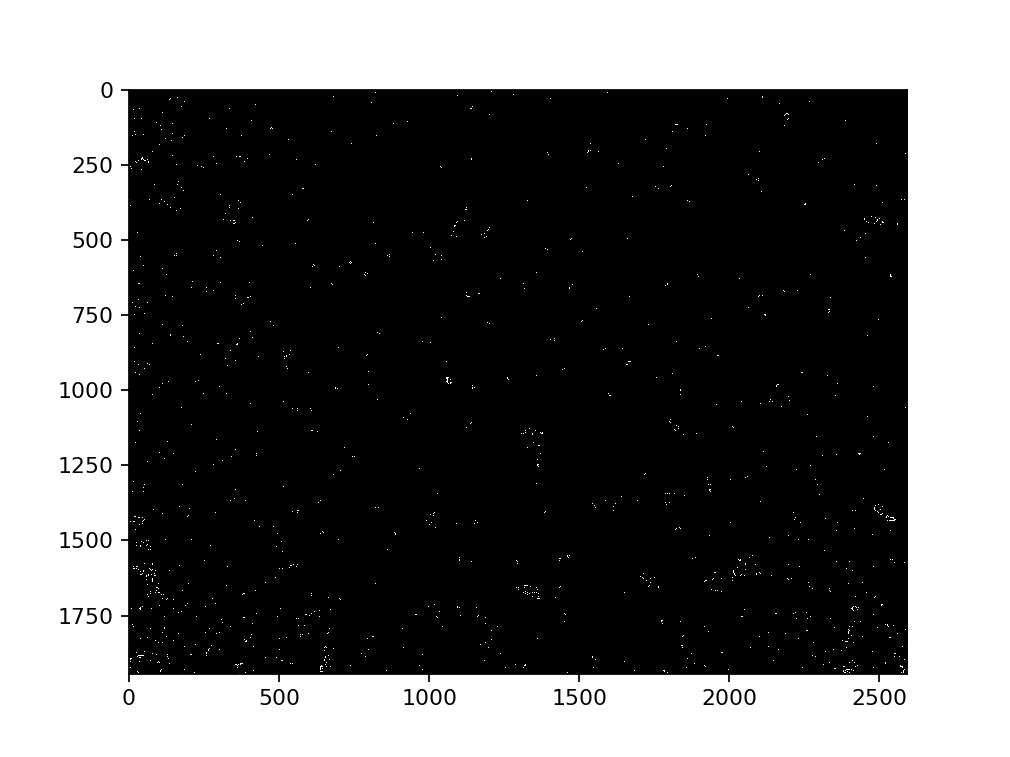

In [223]:
edges = np.zeros_like(photo_grey_nobg)
edges[elevation_map < np.mean(elevation_map)+(4*np.std(elevation_map))] = 0
edges[elevation_map >= np.mean(elevation_map)+(4*np.std(elevation_map))] = 255

plt.figure()
plt.imshow(edges,cmap=plt.cm.gray)

## Choose only detected particles whose particle edges are in-focus

<IPython.core.display.Javascript object>


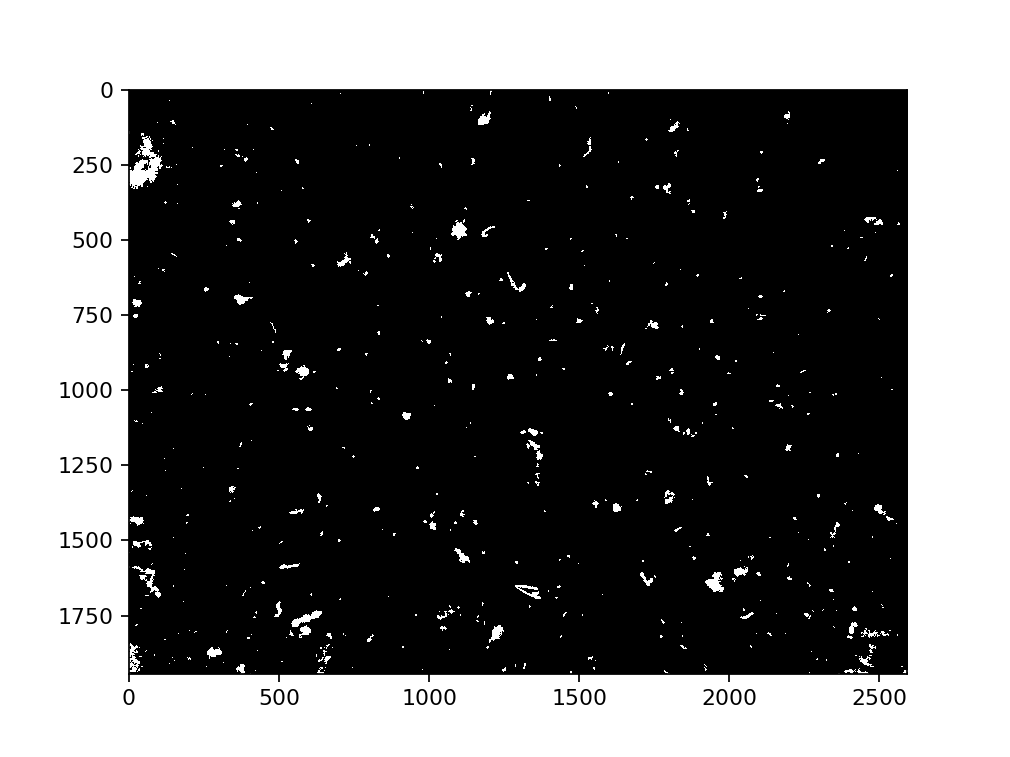

In [224]:
infocus_object_img = np.zeros_like(labeled_edges)
infocus_particle_list=np.unique(labeled_particles[edges+markers_fill>255])
for p in infocus_particle_list:
       infocus_object_img[labeled_particles==p]=p
    
infocus_object_img_mask=np.zeros_like(infocus_object_img)
infocus_object_img_mask[infocus_object_img>0]=255
plt.figure()
plt.imshow(infocus_object_img_mask, cmap=plt.cm.gray)


# The properties of these detected particles are then measured and recorded in a CSV file and an image of each individual particle is saved.

In [86]:
scale = .0855
count = 0
particle_area = []
particle_ESD = []
particle_perimeter = []
particle_major_axis= []
particle_minor_axis= []
particle_numberID = []
#particle_coordinates = []
bounding_box = []

scale_area = scale**2   #square pixels per square micron
properties = measure.regionprops(infocus_object_img)
for x in properties:
    count = count +1
    px_area=x.area
    um_area = px_area / scale_area
    min_axis = x.minor_axis_length / scale
    maj_axis = x.major_axis_length / scale
    perim = x.perimeter / scale
    ESD = 2*(math.sqrt(um_area/math.pi))
    particle_perimeter.append(perim)
    particle_major_axis.append(maj_axis)
    particle_minor_axis.append(min_axis)
    particle_area.append(um_area)
    particle_ESD.append(ESD)
    particle_numberID.append(count)
    edge_area=elevation_map[x.bbox[0]:x.bbox[2],x.bbox[1]:x.bbox[3]]
    max_edge_intensity = np.max(edge_area)
#        particle_coordinates.append(np.ndarray.tolist(x.coords))
    bounding_box.append(str([x.bbox[0],x.bbox[2],x.bbox[1],x.bbox[3]]))
